In [1]:
using Plots
using Random: MersenneTwister
using StatsBase: mean, std, cor

include("../src/Simulation.jl")
using .Simulation: Param, Model, run!, C_rate, Strategy, C, D

include("../src/Network.jl")
using .Network: mat_degree

include("../src/ColorScheme.jl")
using .ColorScheme
const CS = ColorScheme

println("Julia $(VERSION)")
println("Thread count: $(Threads.nthreads())")

Julia 1.10.2
Thread count: 12


In [2]:
trials = 100
p = Param(
    N = 100,
    k₀ = 4,
    generations = 10_000,
    C_rate₀ = 0.0,
    relationship_increment_factor = 1.0,
    resource_decrement_factor = 0.02,
    resource_limit_μ = 0.5,
    b = 1.8,
    peak_node_variability = 0,
    resource_limit_β = 0.7,
    resource_limit_σ = 0.1,
)
model_vec_vec = []

# Execute simulations
for _ in 1:trials
    random_seed = rand(1:typemax(Int16))
    m = Model(p, MersenneTwister(random_seed))
    model_vec = run!(m, MersenneTwister(random_seed), :full)
    push!(model_vec_vec, model_vec)
end;

In [3]:
default(
    fontfamily="Times New Roman",
    titlefontsize=16,
    guidefontsize=14,
    tickfontsize=11,
    legendfontsize=11,
    margin=5Plots.mm,
    dpi=600,
    linewidth=2,
);

In [86]:
function moving_average(data::Vector{<:Real}, window_size::Int = 10)::Vector{Float64}
    return if window_size > 0
        [mean(data[max(1, i-window_size):min(end, i+window_size)]) for i in 1:length(data)]
    else
        Float64.(data)
    end
end

function calc_prime_node_shift_vec(prime_node_vec::Vector{Int}, N::Int = 100)::Vector{Float64}
    env_var_vec = abs.(prime_node_vec[2:end] .- prime_node_vec[1:(end-1)])

    return Float64.([x > Int(N / 2) ? N - x : x for x in env_var_vec])
end

function calc_mean_resource_diff(strategy_vec::Vector{Strategy}, resource_vec::Vector{Float64})::Float64
    C_mean_resouce = mean(resource_vec[findall(==(C), strategy_vec)])
    D_mean_resouce = mean(resource_vec[findall(==(D), strategy_vec)])
    C_mean_resouce = isnan(C_mean_resouce) ? 0.0 : C_mean_resouce
    D_mean_resouce = isnan(D_mean_resouce) ? 0.0 : D_mean_resouce
    return C_mean_resouce - D_mean_resouce
end

function calc_mean_degree_diff(strategy_vec::Vector{Strategy}, degree_vec::Vector{Int})::Float64
    C_mean_degree = mean(degree_vec[findall(==(C), strategy_vec)])
    D_mean_degree = mean(degree_vec[findall(==(D), strategy_vec)])
    C_mean_degree = isnan(C_mean_degree) ? 0.0 : C_mean_degree
    D_mean_degree = isnan(D_mean_degree) ? 0.0 : D_mean_degree
    return C_mean_degree - D_mean_degree
end

function calc_cross_cor(x::Vector{<:Real}, y::Vector{<:Real}, moving_average_window_size::Int = 10, lag_vec::AbstractVector = -50:1:50)::Vector{Float64}
    l = min(length(x), length(y))
    max_lag = maximum(lag_vec)

    if l <= max_lag
        @show x
        @show y
        return [0.0]
    end

    _x = x[(end - l + 1):end]
    _y = y[(end - l + 1):end]

    if moving_average_window_size > 0
        _x = moving_average(_x, moving_average_window_size)
        _y = moving_average(_y, moving_average_window_size)
    end
    
    return [cor(_x[(max_lag+1):(end-max_lag)], _y[(max_lag+1+lag):(end-max_lag+lag)]) for lag in lag_vec]
end

function calc_cor(x_vec_vec::Vector{Vector{Float64}}, y_vec_vec::Vector{Vector{Float64}}, moving_average_window_size::Int = 10)::Tuple{Float64, Float64}
    _x_vec_vec = [moving_average(x_vec, moving_average_window_size) for x_vec in x_vec_vec]
    _y_vec_vec = [moving_average(y_vec, moving_average_window_size) for y_vec in y_vec_vec]

    cor_vec = [cor(x_vec, y_vec) for (x_vec, y_vec) in zip(_x_vec_vec, _y_vec_vec)]

    return mean(cor_vec), std(cor_vec)
end;

In [28]:
# Variables
C_rate_vec_vec = [[C_rate(m) for m in model_vec] for model_vec in model_vec_vec]
degree_vec_vec_vec = [[mat_degree(m.relation_mat) for m in model_vec] for model_vec in model_vec_vec]
θ_vec_vec = [model_vec[1].resource_limit_vec for model_vec in model_vec_vec]
strategy_vec_vec_vec = [[m.strategy_vec for m in model_vec] for model_vec in model_vec_vec]
resource_vec_vec_vec = [[m.resource_vec for m in model_vec] for model_vec in model_vec_vec]

C_rate_var_vec_vec = [C_rate_vec[2:end] .- C_rate_vec[1:(end-1)] for C_rate_vec in C_rate_vec_vec]
env_var_vec_vec = [θ_vec[2:end] .- θ_vec[1:(end-1)] for θ_vec in θ_vec_vec]
degree_SD_vec_vec = [[std(degree_vec) for degree_vec in degree_vec_vec] for degree_vec_vec in degree_vec_vec_vec]
hub_count_vec_vec = [[Float64(sum(degree_vec .>= 10)) for degree_vec in degree_vec_vec] for degree_vec_vec in degree_vec_vec_vec]
mean_resource_diff_vec_vec =  [[calc_mean_resource_diff(s_vec, r_vec) for (s_vec, r_vec) in zip(s_vec_vec, r_vec_vec)] for (s_vec_vec, r_vec_vec) in zip(strategy_vec_vec_vec, resource_vec_vec_vec)]
mean_degree_diff_vec_vec = [[calc_mean_degree_diff(s_vec, d_vec) for (s_vec, d_vec) in zip(s_vec_vec, d_vec_vec)] for (s_vec_vec, d_vec_vec) in zip(strategy_vec_vec_vec, degree_vec_vec_vec)];

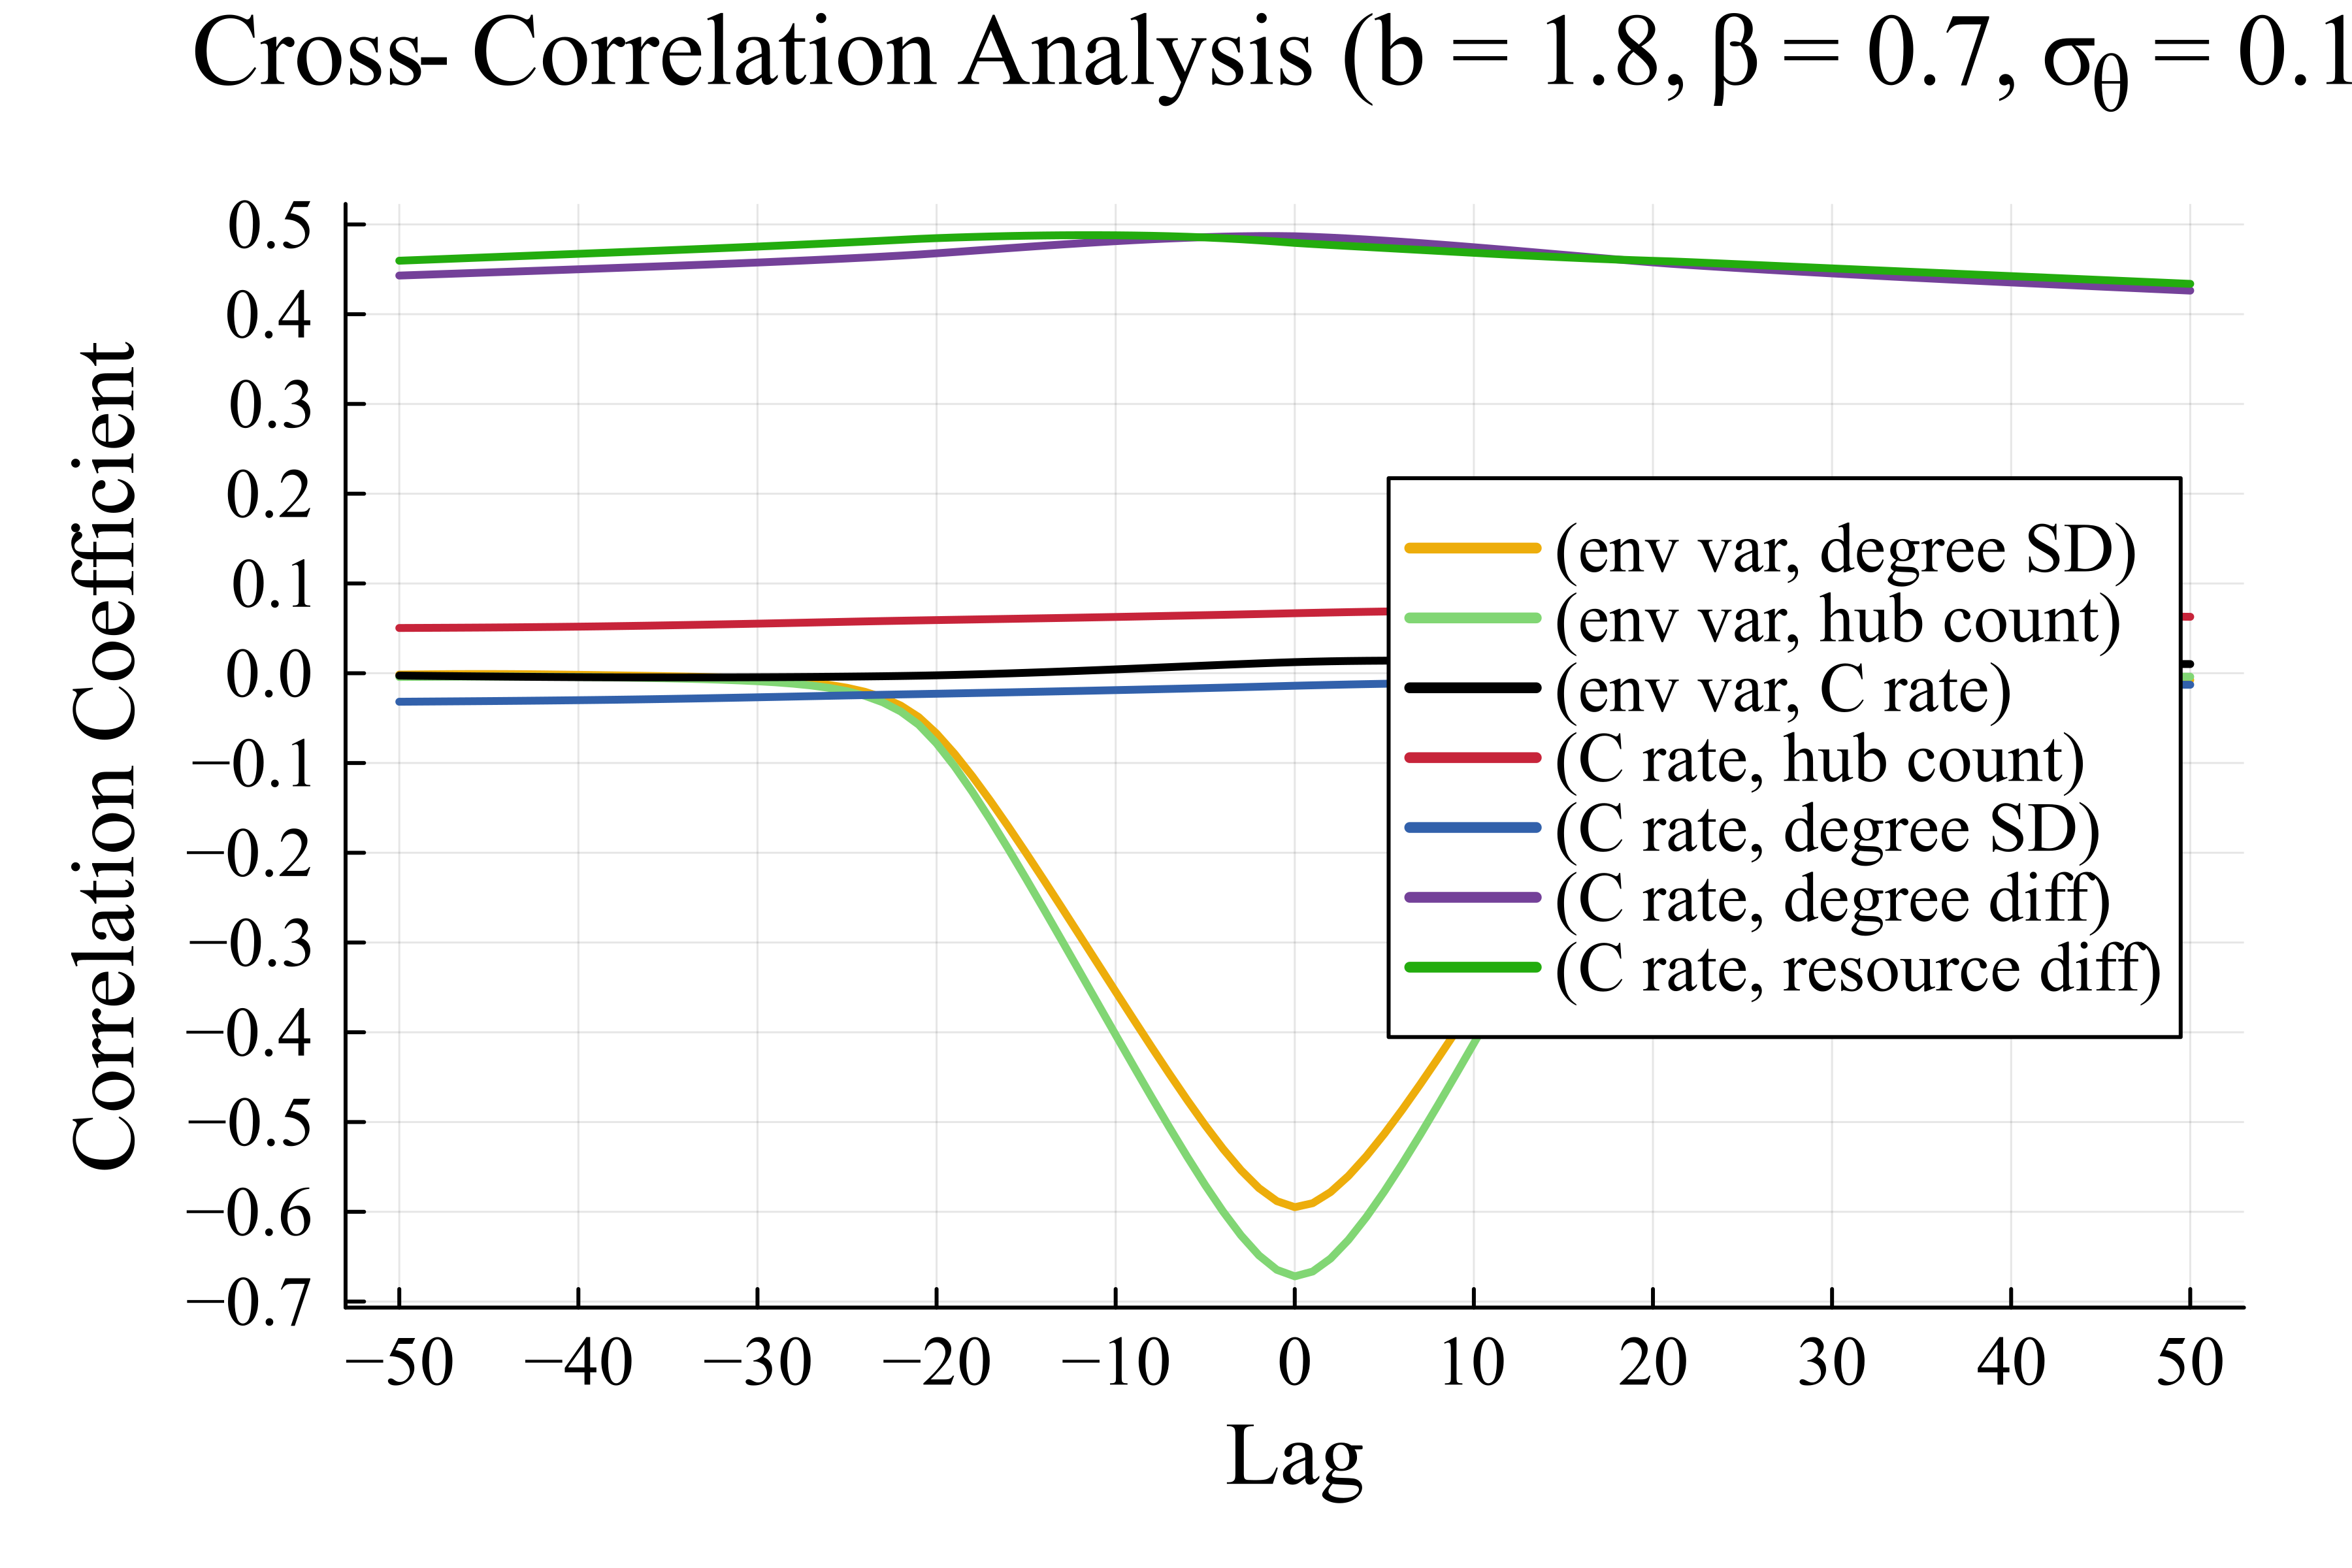

Memo: Lagがマイナスの場合はyが先行、プラスの場合はxが先行


In [40]:
time_lag_vec = -50:1:50

# Plot base
plt = plot(
    xticks=minimum(time_lag_vec):10:maximum(time_lag_vec),
    xlabel="Lag",
    yticks=-1.0:0.1:1.0,
    ylabel="Correlation Coefficient",
    title="Cross-Correlation Analysis (b = $(p.b), \\beta = $(p.resource_limit_β), \\sigma_{\\theta} = $(p.resource_limit_σ))",
    legend=:right,
)

function plot_cross_correlation!(plt::Plots.Plot, time_lag_vec::AbstractVector, vec_vec1::Vector{Vector{Float64}}, vec_vec2::Vector{Vector{Float64}}, label::String, color::String)::Nothing
    cross_cor_vec_vec = [calc_cross_cor(x, y) for (x, y) in zip(vec_vec1, vec_vec2)]
    mean_vec = [mean([cross_cor_vec_vec[t][g] for t in 1:trials]) for g in 1:length(time_lag_vec)]
    std_vec = [std([cross_cor_vec_vec[t][g] for t in 1:trials]) for g in 1:length(time_lag_vec)]

    plot!(
        plt,
        time_lag_vec,
        mean_vec,
        label=label,
        lc=color,
        # ribbon=std_vec,
        # fillcolor=color,
    )

    return
end

# Plot cross-correlation
plot_cross_correlation!(plt, time_lag_vec, θ_vec_vec, degree_SD_vec_vec,          "(env var, degree SD)",    CS.ORANGE)
plot_cross_correlation!(plt, time_lag_vec, θ_vec_vec, hub_count_vec_vec,          "(env var, hub count)",    CS.LIGHT_GREE)
plot_cross_correlation!(plt, time_lag_vec, θ_vec_vec, C_rate_vec_vec,             "(env var, C rate)",       CS.BLACK)
plot_cross_correlation!(plt, time_lag_vec, C_rate_vec_vec,  hub_count_vec_vec,          "(C rate, hub count)",     CS.RED)
plot_cross_correlation!(plt, time_lag_vec, C_rate_vec_vec,  degree_SD_vec_vec,          "(C rate, degree SD)",     CS.BLUE)
plot_cross_correlation!(plt, time_lag_vec, C_rate_vec_vec,  mean_degree_diff_vec_vec,   "(C rate, degree diff)",   CS.PURPLE)
plot_cross_correlation!(plt, time_lag_vec, C_rate_vec_vec,  mean_resource_diff_vec_vec, "(C rate, resource diff)", CS.GREEN)

display(plt)
savefig(plt, "img/Fig5c.png")
println("Memo: Lagがマイナスの場合はyが先行、プラスの場合はxが先行");

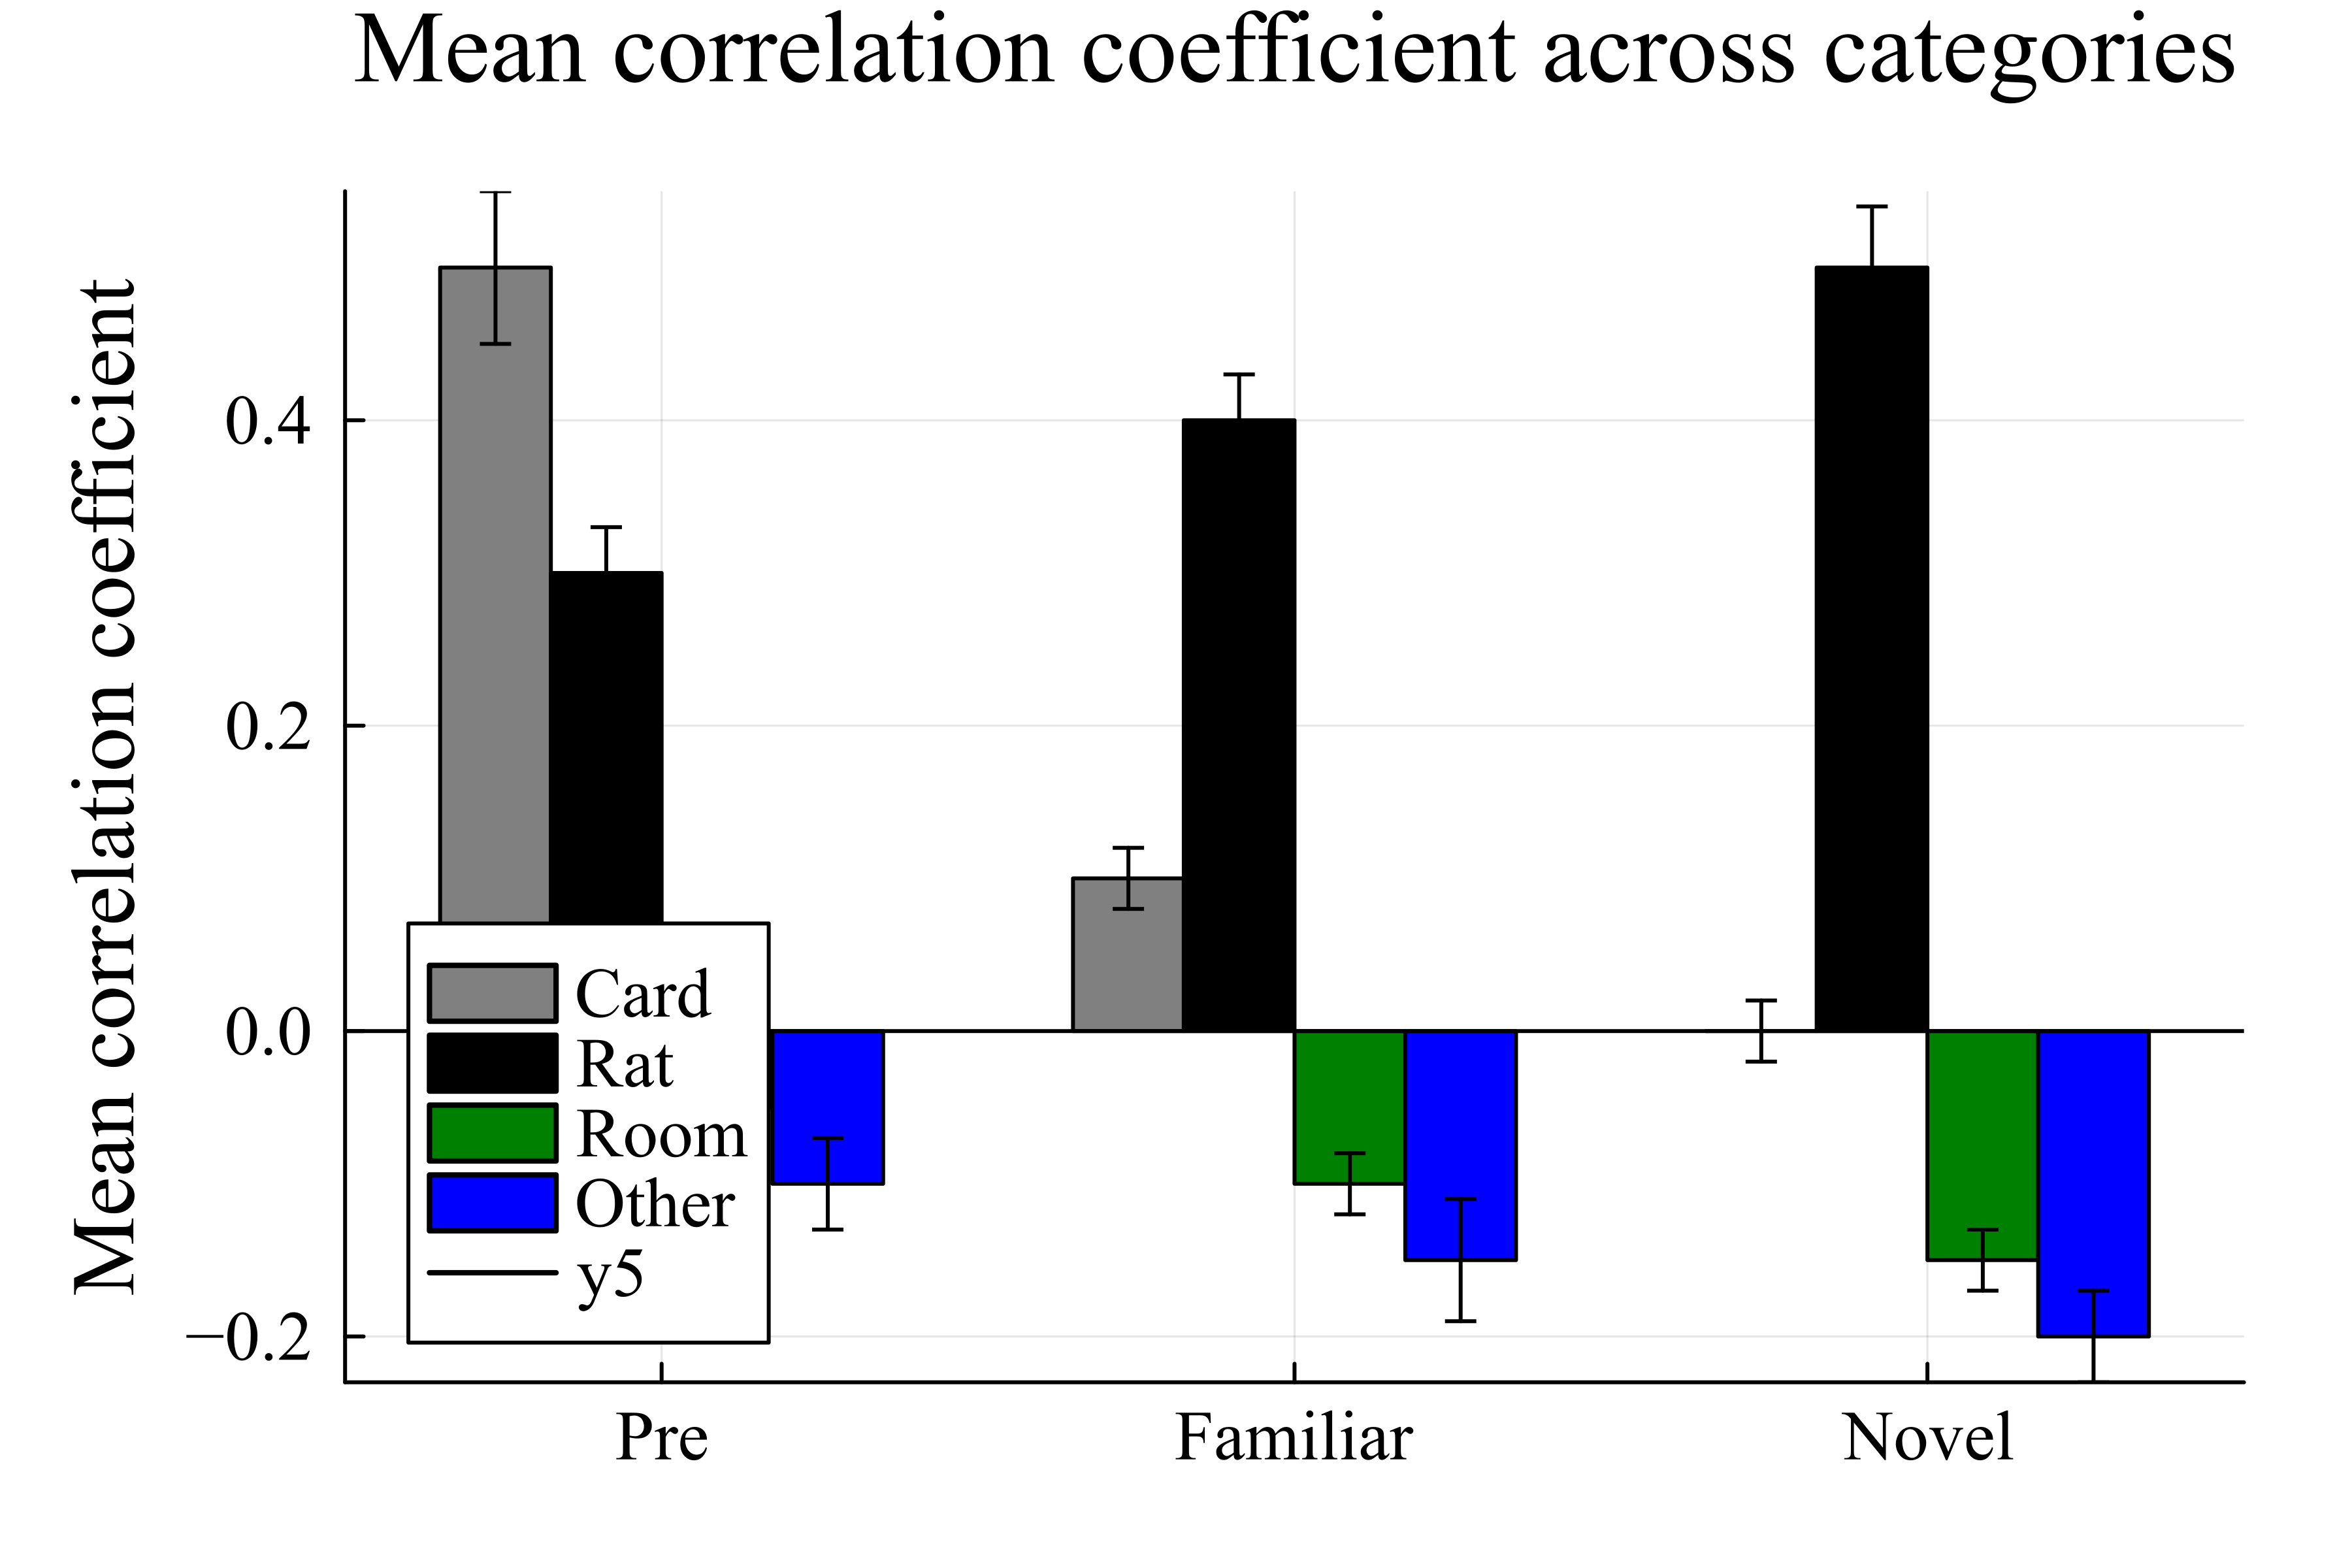

In [176]:
using StatsPlots

# サンプルデータ
categories = ["Pre", "Familiar", "Novel"]

# 4つの系列のデータ（Card, Rat, Room, Other）
card_corr = [0.5, 0.1, 0.0]      # Card
rat_corr = [0.3, 0.4, 0.5]       # Rat
room_corr = [-0.05, -0.1, -0.15] # Room
other_corr = [-0.1, -0.15, -0.2] # Other

# エラーバー（仮の値）
card_err = [0.05, 0.02, 0.02]
rat_err = [0.03, 0.03, 0.04]
room_err = [0.02, 0.02, 0.02]
other_err = [0.03, 0.04, 0.03]

# groupedbarでグループ化された棒グラフをプロット
groupedbar(categories, [card_corr rat_corr room_corr other_corr], 
    yerr=[card_err rat_err room_err other_err], 
    bar_position=:dodge, bar_width=0.7, 
    label=["Card" "Rat" "Room" "Other"], 
    color=[:gray :black :green :blue])

# y=0 のラインを追加
hline!([0], linestyle=:solid, color=:black)

# グラフのラベルとタイトル
xlabel!("")
ylabel!("Mean correlation coefficient")
title!("Mean correlation coefficient across categories")


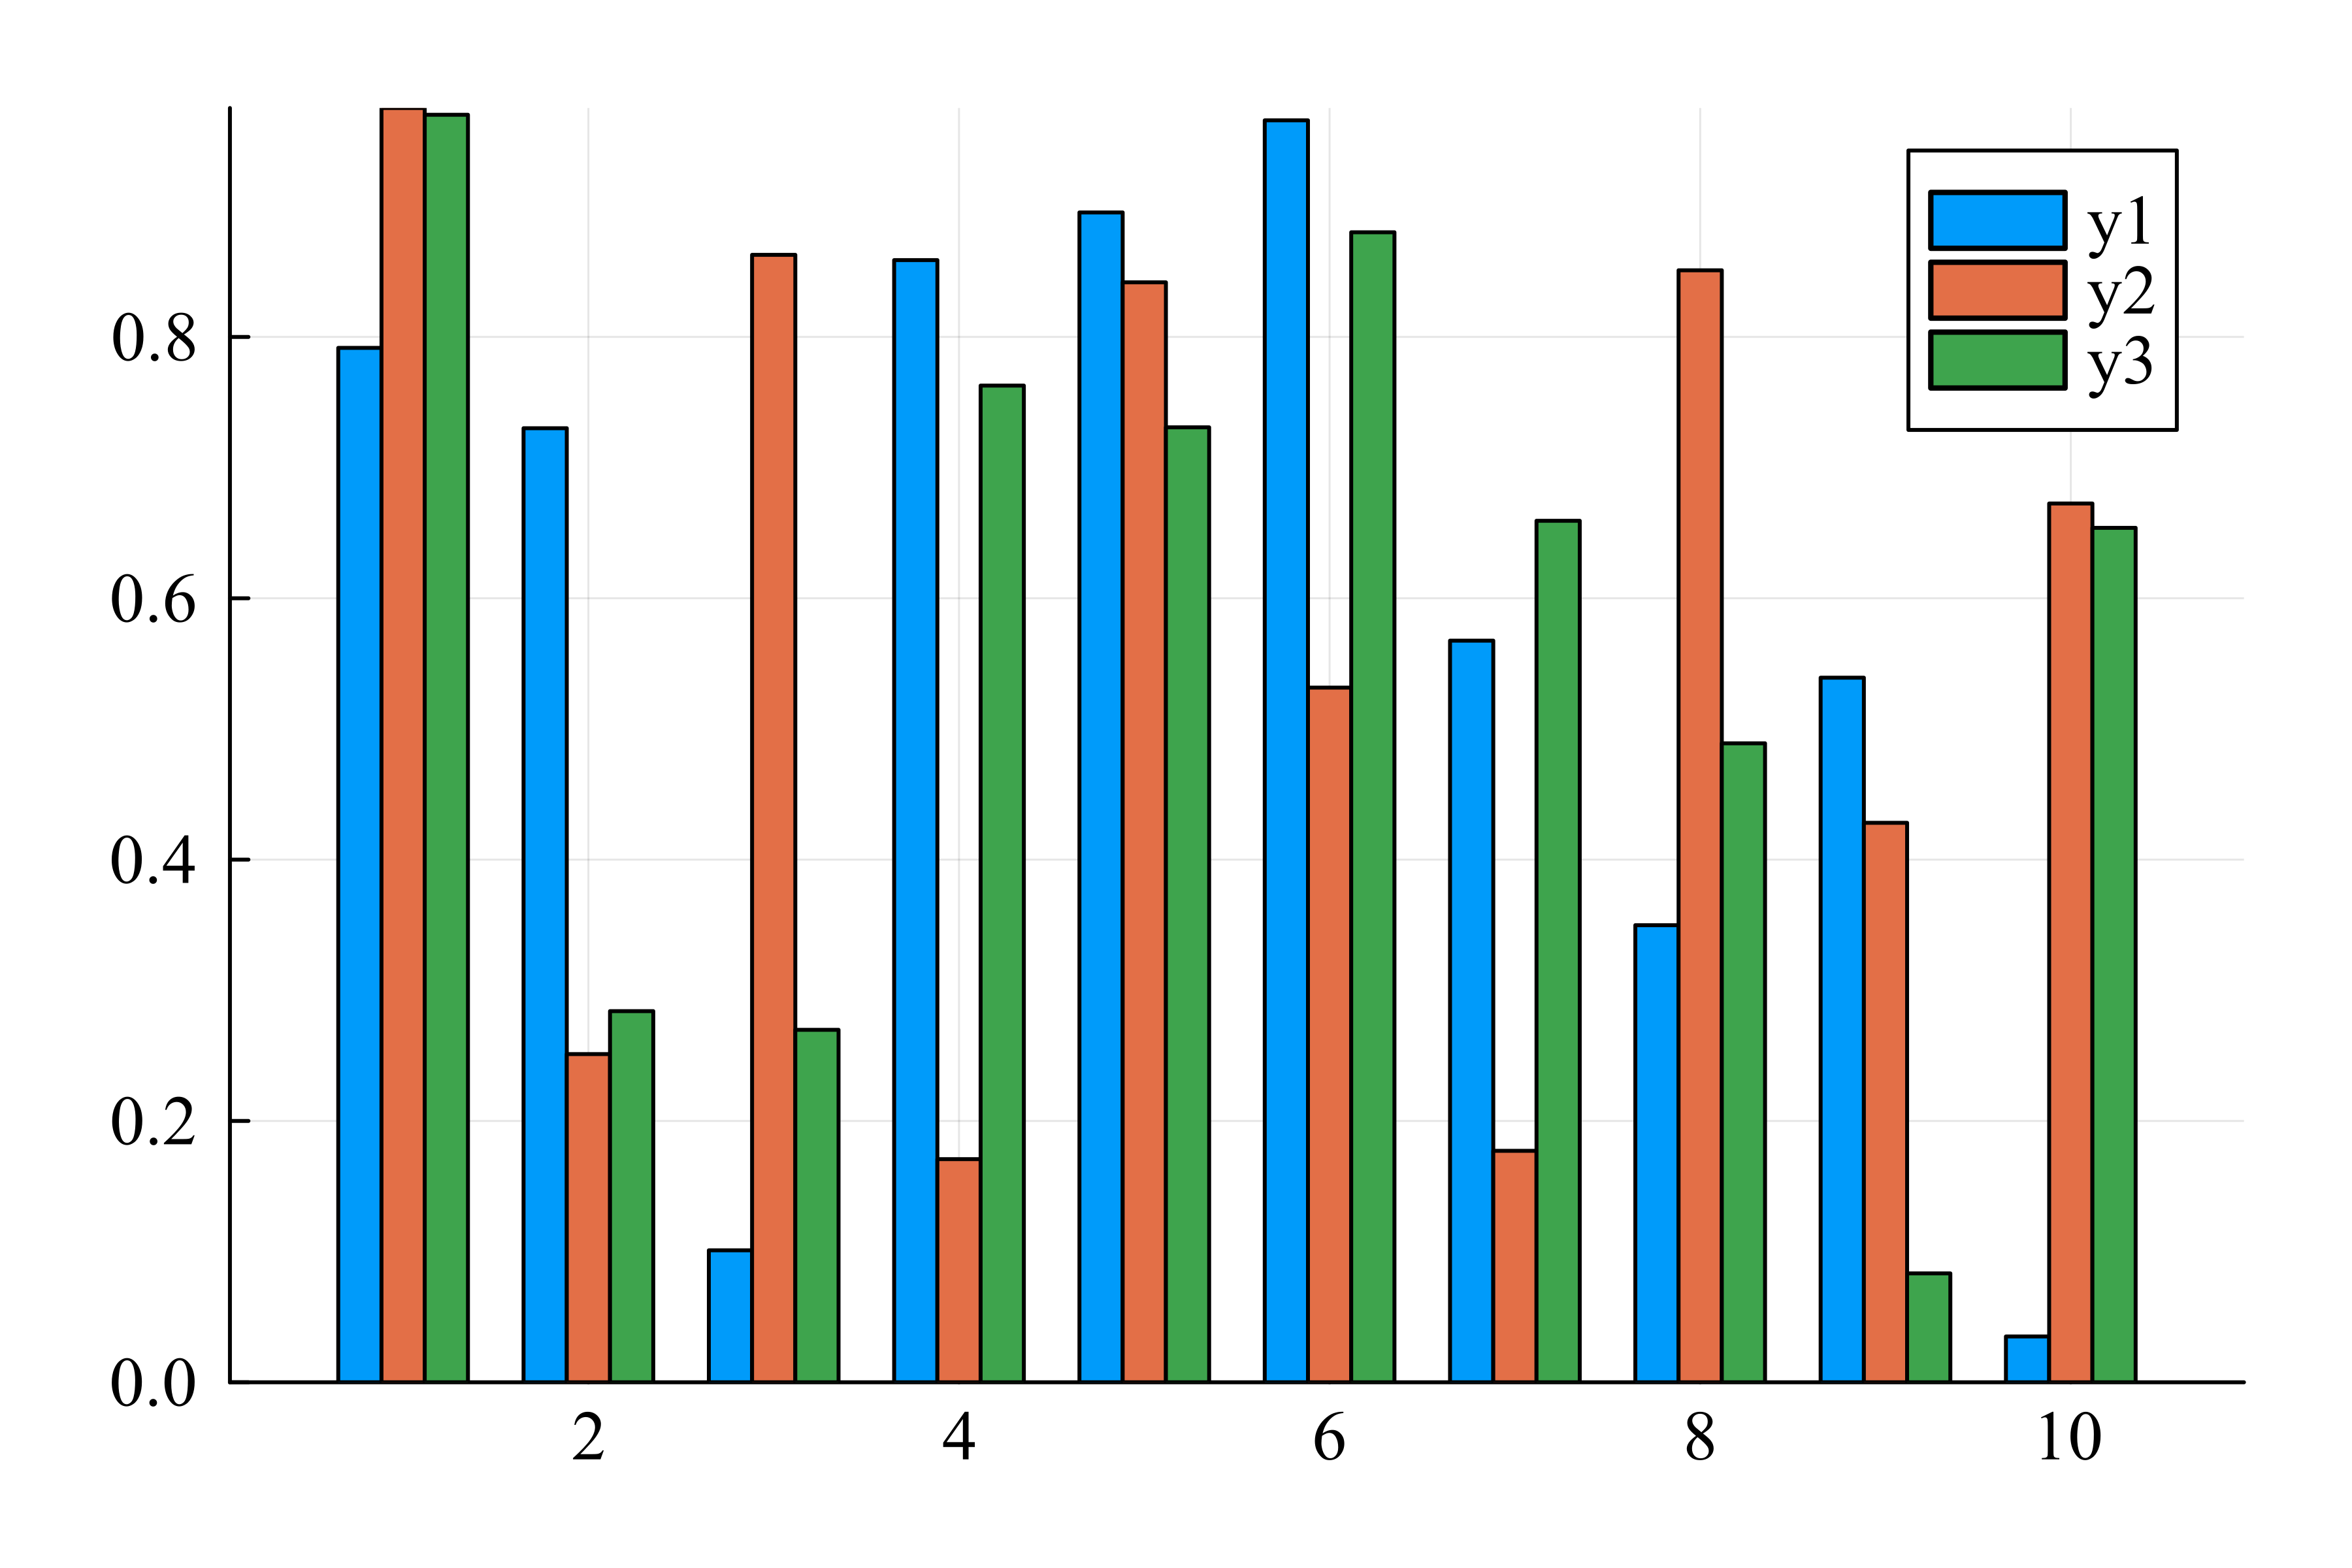

In [174]:
using StatsPlots
groupedbar(rand(10,3), bar_position = :dodge, bar_width=0.7)

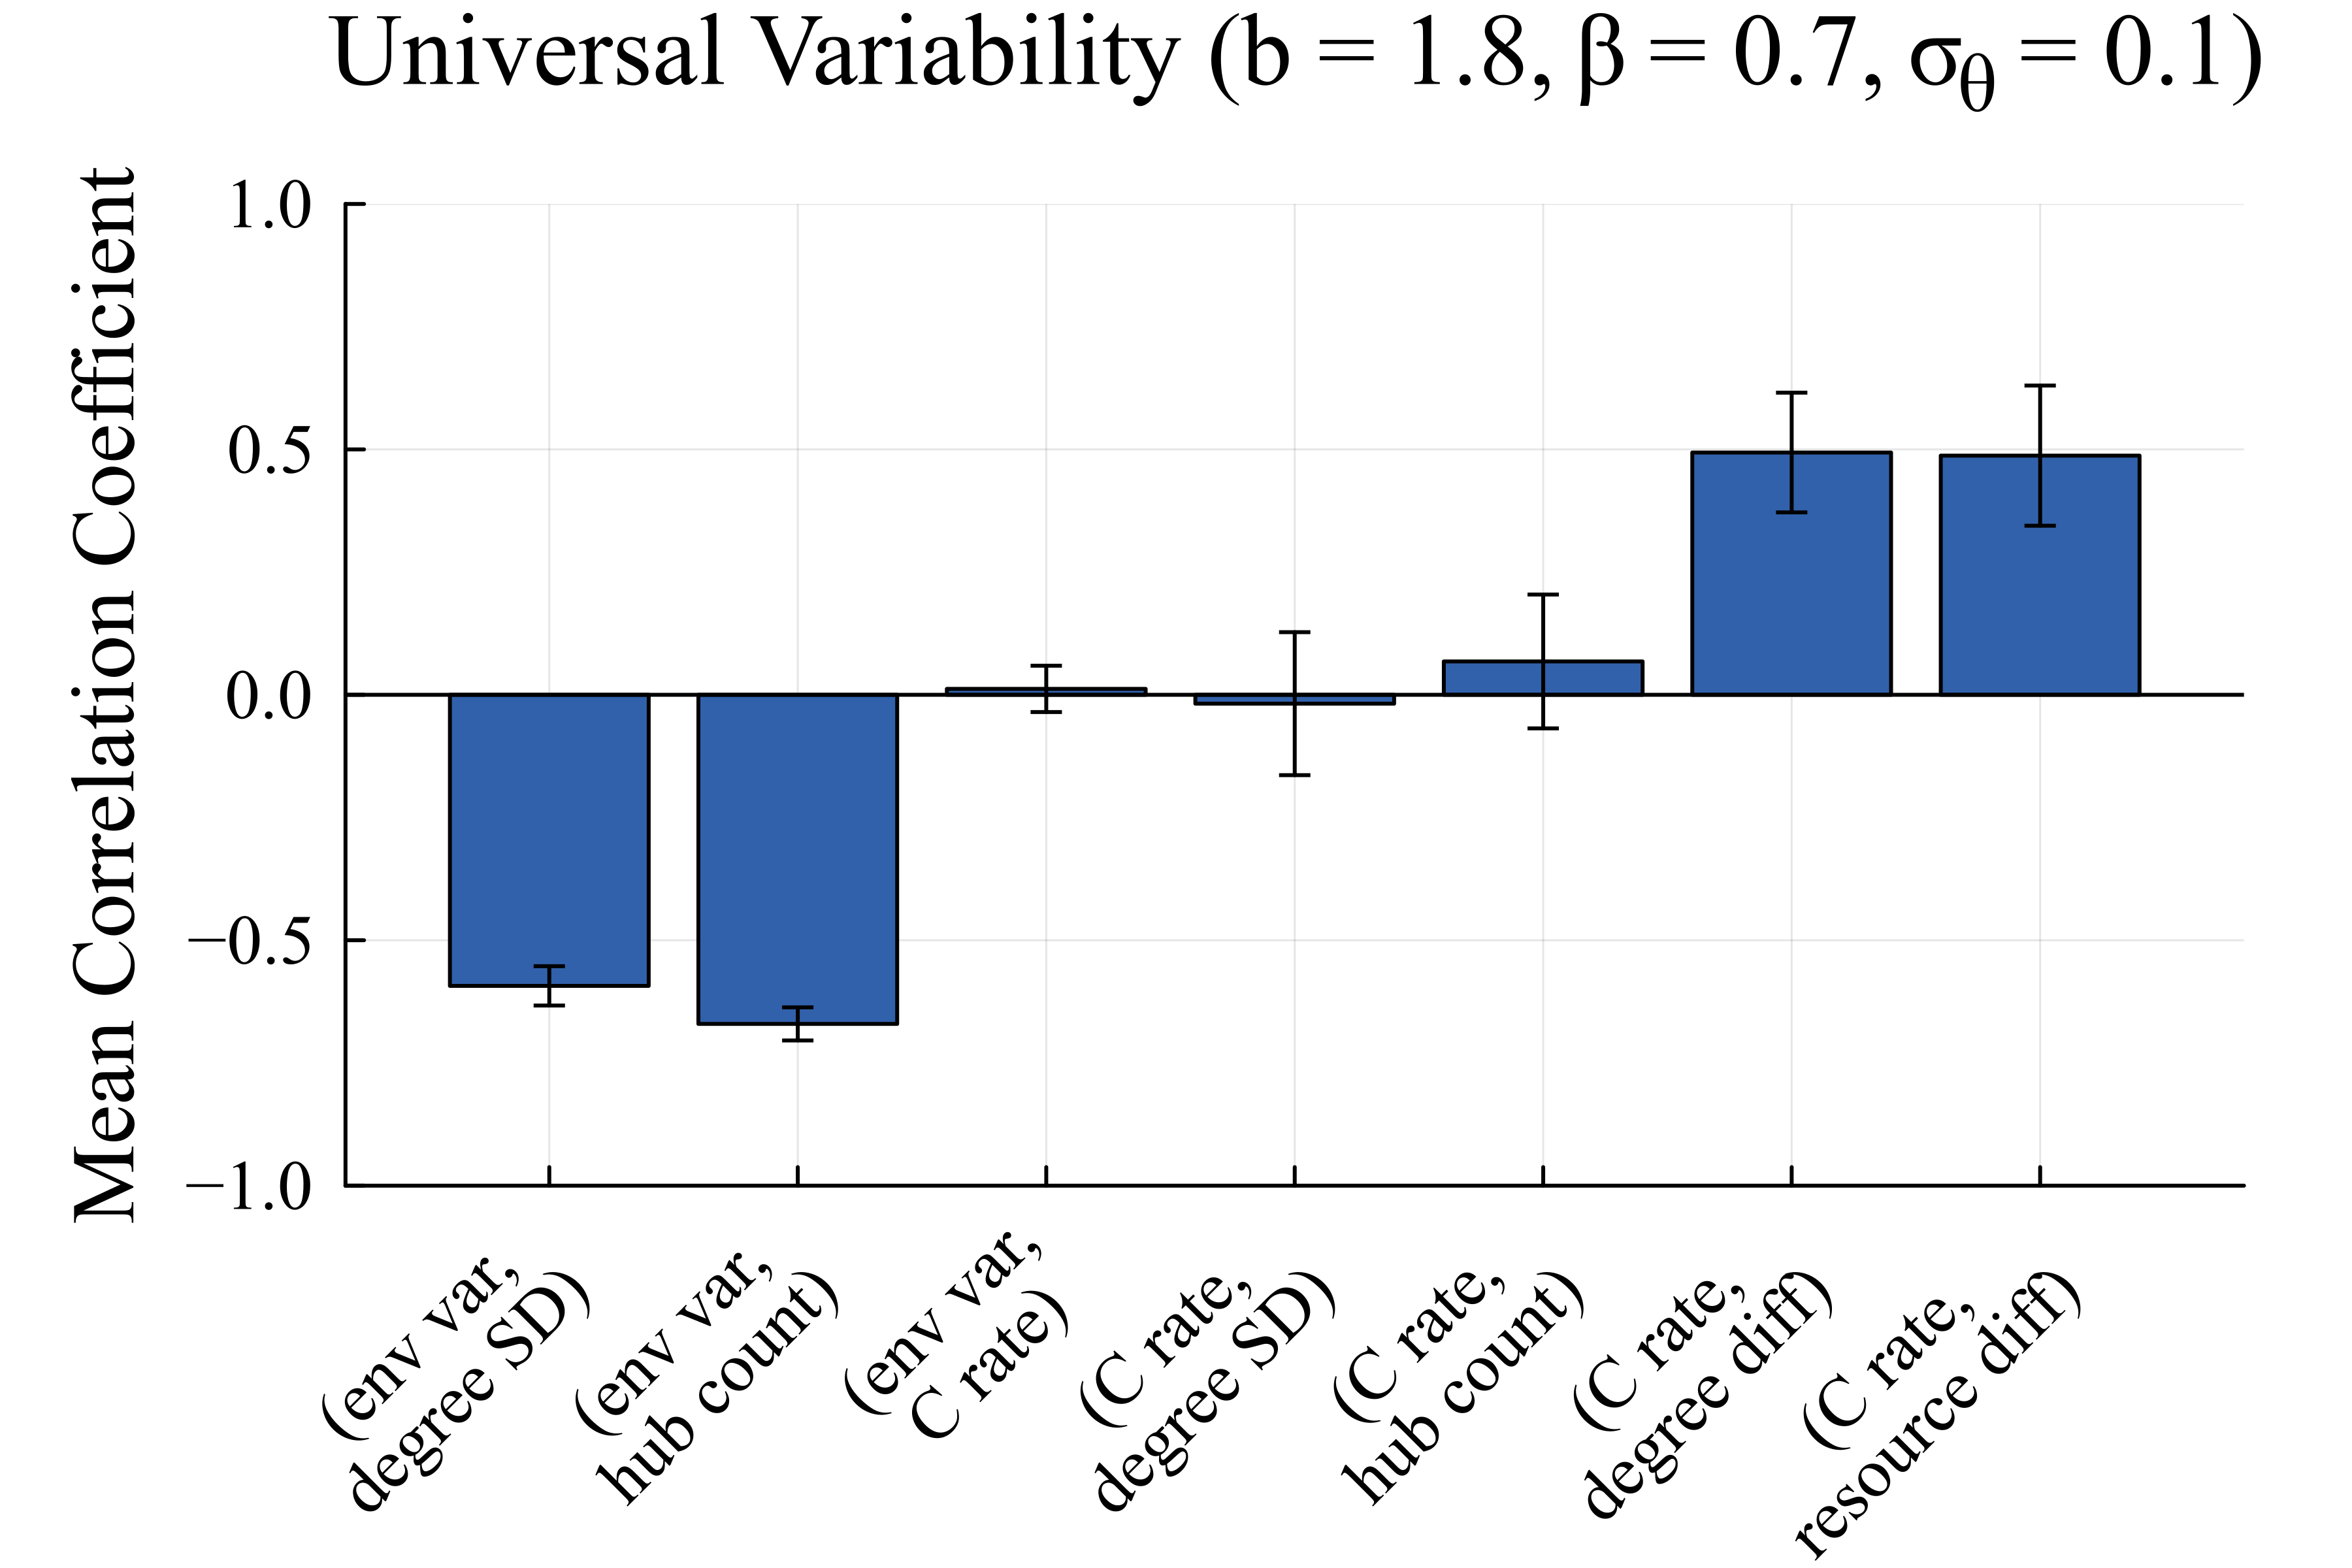

In [225]:
label_vec = [
    "(env var,\ndegree SD)",
    "(env var,\nhub count)",
    "(env var,\nC rate)",
    "(C rate,\ndegree SD)",
    "(C rate,\nhub count)",
    "(C rate,\ndegree diff)",
    "(C rate,\nresource diff)",
]
variable_pair_vec = [
    (θ_vec_vec, degree_SD_vec_vec),
    (θ_vec_vec, hub_count_vec_vec),
    (θ_vec_vec, C_rate_vec_vec),
    (C_rate_vec_vec, degree_SD_vec_vec),
    (C_rate_vec_vec, hub_count_vec_vec),
    (C_rate_vec_vec, mean_degree_diff_vec_vec),
    (C_rate_vec_vec, mean_resource_diff_vec_vec),
]

mean_cor_vec = []
std_cor_vec = []

for (x, y) in variable_pair_vec
    mean_cor, std_cor = calc_cor(x, y)
    push!(mean_cor_vec, mean_cor)
    push!(std_cor_vec, std_cor)
end

bar(label_vec, mean_cor_vec, yerr=std_cor_vec, label=false, ylim=(-1, 1), c=CS.BLUE, xrotation=45)
hline!([0], color=:black, label=false)
ylabel!("Mean Correlation Coefficient")
title!("Universal Variability (b = $(p.b), \\beta = $(p.resource_limit_β), \\sigma_{\\theta} = $(p.resource_limit_σ))")